In [1]:
#!/usr/bin/python
from __future__ import absolute_import

import sys
sys.path.append("../../")

import numpy as np
#from tensorflow import keras
import os
import argparse
import copy
import random
import time
import torch

from shapley.apps import Label, InclusionExclusion
from shapley.loader import FashionMnist, MNIST, Flower, CIFAR
from shapley.measures import KNN_Shapley, KNN_LOO, G_Shapley, LOO, TMC_Shapley, FastWeightedShapley
from shapley.utils.plotter import LabelPlotter, PoisoningPlotter

%matplotlib inline
# import global vars
from init import set_seed

seed = 1023
set_seed(seed)
torch.backends.cudnn.enabled = False

assert torch.cuda.is_available(), "CUDA not availabel"

2023-07-22 08:01:06.988300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 08:01:07.961969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term
Loaded Global Variables!


/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_train = 60000
num_test = 10000
datasource = "fmnist"
model_family = "resnet18"
app_name = "inclusion_exclusion"
model_checkpoint_dir = f"../../checkpoints/{app_name}/{datasource}"

if not os.path.exists(model_checkpoint_dir):
    os.makedirs(model_checkpoint_dir)


#loader = MNIST(num_train=num, one_hot=False, shuffle=True, by_label=True)
loader = FashionMnist(num_train=num_train,num_test = num_test, all_classes=True, seed = seed)
# loader = Flower(num_train=num)
X_data, y_data, X_test_data, y_test_data = loader.prepare_data()
print(X_test_data.shape, X_data.shape)

(10000, 1, 28, 28) (50000, 1, 28, 28)


In [3]:
start = time.time()

measure_fast_weighted_shapley = FastWeightedShapley(K = 5, model_checkpoint_dir=model_checkpoint_dir)
app = InclusionExclusion(X=X_data
                        , y=y_data
                        , X_test=X_test_data
                        , y_test=y_test_data
                        , method_name = "fw_shapley"
                        , app_name = app_name
                        , dataset = "cifar"
                        , model_family=model_family
                        , model_checkpoint_dir=model_checkpoint_dir)
exclusion_scores = app.run(measure_fast_weighted_shapley)


Loading existing resnet18 model weights
Calculating SHAP scores
Loaded model acc 91.21 on test set
Extracting features from resnet model
Loading existing explainer model weights


Inference: 100%|██████████| 30/30 [00:05<00:00,  5.95batch/s]
/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/home/sidtandon/Sid/GitRepo/fast-data-shapley/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1222: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 7

(array([1.5000e+01, 2.8000e+01, 4.3000e+01, 7.2600e+02, 3.5192e+04,
        1.0000e+00, 5.9990e+03, 1.0000e+00, 4.0000e+00, 1.7991e+04]),
 array([0.01624645, 0.01699121, 0.01773596, 0.01848072, 0.01922548,
        0.01997023, 0.02071499, 0.02145974, 0.0222045 , 0.02294926,
        0.02369401]),
 <BarContainer object of 10 artists>)

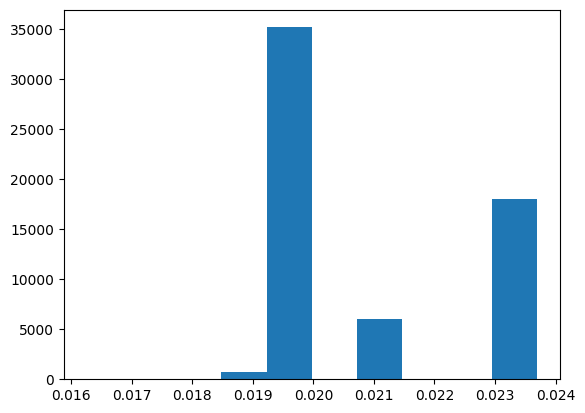

In [5]:
import matplotlib.pyplot as plt
shap_scores = np.load("../../results/inclusion_exclusion/fmnist/fw_shapley_shap_scores.npy")[:,0]
plt.hist(shap_scores)

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

shap_scores = np.load("../../results/inclusion_exclusion/fmnist/fw_shapley_shap_scores.npy")[:,0]
indexes = np.argsort(shap_scores)[::-1].copy()


plt.figure(figsize=(20, 20))

print()
print(np.bincount(y_data[indexes[:6100]]))
# for i, index in enumerate(indexes[:100]):
#     inst_x = X_data[index]
#     inst_x = inst_x.reshape(28, 28)
#     # inst_x = Image.fromarray(np.uint8(inst_x))
#     plt.subplot(20, 5, i+1)
#     plt.imshow(inst_x, cmap='gray')
#     plt.title(y_data[index])


[   0    0    0    0    0    6    0 5994    0  100]


<Figure size 2000x2000 with 0 Axes>